In [17]:
# ANN classification on MNIST dataset
# loading libraries
import sys
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from keras.models import Model
import keras
from tqdm import tqdm
from keras.callbacks import Callback
from keras.regularizers import l2

In [18]:
# function to load dataset from keras
def load_dataset(name):
    # load dataset
    (trainX, trainY), (testX, testY) = name.load_data()
    # shape of dataset
    train_shape, test_shape = [trainX.shape, trainY.shape], [testX.shape, testY.shape]
    num_classes = len(np.unique(trainY))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY, train_shape, test_shape

In [19]:
trainX, trainY, testX, testY, train_shape, test_shape = load_dataset(mnist)

In [20]:
# processing the data
def data_process(trainX, testX):
    # convert from integers to floats
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
    # normalize to range 0-1
    trainX = trainX / 255.0
    testX = testX / 255.0
    trainX = trainX.reshape((len(trainX), np.prod(trainX.shape[1:])))
    testX = testX.reshape((len(testX), np.prod(testX.shape[1:])))
    # return normalized images
    return trainX, testX

In [21]:
# diagnostic plots
def diagnostic_plots(history):
    # plot for loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='red', label='train')
    plt.plot(history.history['val_loss'], color='blue', label='test')
    plt.legend()
    # plot for accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='red', label='train')
    plt.plot(history.history['val_accuracy'], color='blue', label='test')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
# ann model architecture
def define_model():
    # define model
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
class tqdm_cb(Callback):
    def __init__(self, total):
        super().__init__()
        self.total = total
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.total, desc='Training model')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(loss=logs['loss'], accuracy=logs['accuracy'])

    def on_train_end(self, logs=None):
        self.pbar.close()

def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY, train_shape, test_shape = load_dataset(mnist)
    # process data
    trainX, testX = data_process(trainX, testX)
    # load encoder model
    encoder = keras.models.load_model('../Autoencoders Model/encoder_model.keras')
    encoded_imgs_train = encoder.predict(trainX)
    encoded_imgs_test = encoder.predict(testX)
    # define model
    model = define_model()
    history = model.fit(encoded_imgs_train, trainY, epochs=100, batch_size=64, validation_data=(encoded_imgs_test, testY), verbose=0, callbacks=[tqdm_cb(100)])
    # evaluate model
    _, acc = model.evaluate(encoded_imgs_test, testY, verbose=0)
    print('> Accuracy: %.3f' % (acc * 100.0))
    diagnostic_plots(history)
    # save model , install hp5py
    model.save('ann_model.keras')

313/313 [==============================] - 1s 2ms/step


Training model: 100%|██████████| 100/100 [03:54<00:00,  2.35s/it, accuracy=0.96, loss=0.183]


> Accuracy: 95.790


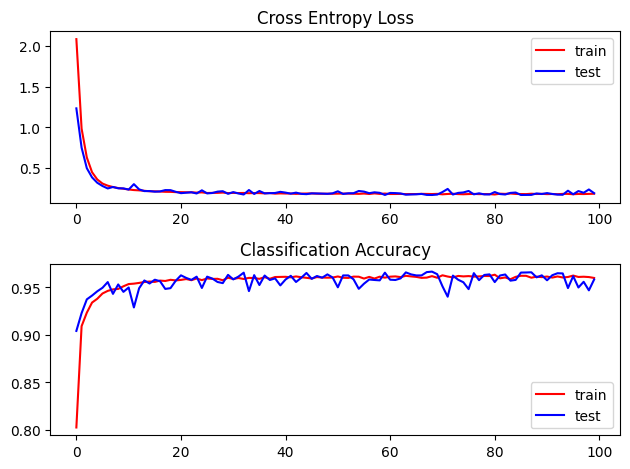

In [24]:
run_test_harness()